## Generating the experiments

Automate multiple NS-3 simulation scenarios using Python:

- Number of links

- Link characteristics (data rate, delay)

- Queue types

- App traffic (UDP/TCP, OnOff distribution, etc.)

https://github.com/signetlabdei/sem/blob/master/examples/Propagation%20Samples.ipynb

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))

/tmp/ipykernel_182816/1349929106.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [2]:
import sem
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
sns.set_style("whitegrid")
import random
import pandas as pd
import io


When first building it may take on my dev pc 30 mins, but once run it will take 25 seconds

In [3]:
import sem
ns_path = 'ns-3-dev/'
script = 'multi-links-sem'
campaign_dir = 'testResults'
campaign = sem.CampaignManager.new(
    ns_path=ns_path,
    script=script,
    campaign_dir=campaign_dir,
    overwrite=True,
    max_parallel_processes=2
)


In [4]:
print(campaign)

--- Campaign info ---
script: multi-links-sem
params: {'numLinks': 2.0, 'dataRates': '1Mbps,500Kbps', 'delays': '100ms,200ms', 'queueType': 'ns3::FifoQueueDisc', 'queueMaxSize': '100p', 'transportType': 'udp', 'onTimeType': 'Constant', 'onTimeParam': 1.0, 'offTimeType': 'Constant', 'offTimeParam': 0.5, 'appRate': '1Mbps', 'packetSize': 100.0}
HEAD: a17161947b1f4f61bf7705508ce3ec87a499a02b
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


Try to run this to debug on the shell ./ns3 run "scratch/multi-links-sem --numLinks=2 --dataRates=2Mbps,1Mbps --delays=100ms,200ms"

In [ ]:
    """
    ,
    'queueType':["ns3::FifoQueueDisc"],
    'queueMaxSize': ["10p","50p","100p","500p","1000p"],#list(range(5, 1200,200)),
    'transportType':["udp"],#,"tcp"],
    'onTimeType':["Constant","Exponential"],
    'onTimeParam':["0.8","1.0","1.5","2"],
    'offTimeType':["Constant","Exponential"],
    'offTimeParam':["0.0","0.4","0.5"],
    'appRate':["200Kbps","500Kbps","1Mbps","2Mbps","10Mbps"],
    'packetSize':["512","1000","1400"]
    """

In [5]:
#check the input of the datarates and delays
params = {
    'numLinks':[3], #for now fixed 
    
    'dataRates':["500Kbps,2Mbps,3Mbps","1Mbps,500Kbps,100Kbps","5Mbps,1Mbps,500Kbps"],
    
    'delays': ["100ms,200ms,300ms","300ms,200ms,100ms","500ms,200ms,500ms","1000ms,500ms,1000ms"]


}
runs = 2 #specify how many randomized experiments we want sem to perform for each parameter combination

campaign.run_missing_simulations(params, runs=runs) #this will run 24 experiments

Running simulations: 100%|██████████| 24/24 [00:06<00:00,  3.57simulation/s]


In [6]:
print("There are %s results in the database\n" % len(list(campaign.db.get_complete_results())))
example_result = campaign.db.get_complete_results()[5]
print("This is an example result:\n")
pprint.pprint(example_result)

There are 24 results in the database

This is an example result:

{'meta': {'elapsed_time': 0.5525553226470947,
          'exitcode': 0,
          'id': 'fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54'},
 'output': {'flow_df.csv': 'flow_id,time_first_tx_s,time_first_rx_s,time_last_tx_s,time_last_rx_s,delay_sum_s,jitter_sum_s,last_delay_s,tx_bytes,rx_bytes,tx_packets,rx_packets,lost_packets,times_forwarded,duration,throughput_Mbps,src,dst,src_port,dst_port,protocol,mean_delay,mean-jitter,flow_5tuple\n'
                           '1,1.5008000000000001,2.00288,9.9992,10.916500000000001,3342.48,5.385120000000001,0.9172800000000001,959872,522880,7499,4085,3414,0,9.415700000000001,0.4442622428497084,10.1.1.2,10.1.1.1,49153,9,17,0.8182325581395349,0.0013182668298653611,10.1.1.2-10.1.1.1-49153-9-17\n',
            'multi-link-0-1.pcap': 'RAW',
            'multi-link-0-2.pcap': 'RAW',
            'multi-link-0-3.pcap': 'RAW',
            'multi-link-1-1.pcap': 'RAW',
            'multi-link-1-2.pcap': '

## Parsing the flowmonitor output

In [7]:
"""
@sem.utils.output_labels([
    'flow_id', 'time_first_tx_s', 'time_first_rx_s', 'time_last_tx_s',
    'time_last_rx_s', 'delay_sum_s', 'jitter_sum_s', 'last_delay_s',
    'tx_bytes', 'rx_bytes', 'tx_packets', 'rx_packets', 'lost_packets',
    'times_forwarded', 'duration', 'throughput_Mbps', 'src', 'dst',
    'src_port', 'dst_port', 'protocol', 'mean_delay', 'mean-jitter',
    'flow_5tuple'
])
"""
#@sem.utils.output_labels(['mean-delay-s','mean-jitter-s'])
@sem.utils.output_labels(['mean-delay-s'])
def getDelay_flows(result):
    string_df = result['output']['stdout']
    df = pd.read_csv(io.StringIO(string_df.strip()))
    #print("DataFrame shape:", df.shape) #debug
    #print("Columns:", df.columns.tolist()) #debug

    #return df.values.tolist()
    #return df[['mean_delay','mean-jitter']].iloc[0].values
    return df['mean_delay'].iloc[0]

@sem.utils.output_labels(['jitter-delay-s'])
def getJitter_flows(result):
    string_df = result['output']['stdout']
    df = pd.read_csv(io.StringIO(string_df.strip()))
    #print("DataFrame shape:", df.shape) #debug
    #print("Columns:", df.columns.tolist()) #debug

    #return df.values.tolist()
    #return df[['mean_delay','mean-jitter']].iloc[0].values
    return df['mean-jitter'].iloc[0]



In [8]:
getDelay_flows(example_result),getJitter_flows(example_result)

(0.8182325581395349, 0.0013182668298653)

In [9]:
# Use the parsing function to create a Pandas dataframe
results_delay = campaign.get_results_as_dataframe(getDelay_flows, params=params)
results_jitter = campaign.get_results_as_dataframe(getJitter_flows, params=params)

the runs give the same results a priori (so maybe do only one run)

In [10]:
results_delay

,numLinks,dataRates,delays,queueMaxSize,appRate,onTimeType,offTimeType,queueType,offTimeParam,transportType,onTimeParam,packetSize,RngRun,mean-delay-s
0,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,1,0.418233
1,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,0,0.418233
2,3,"500Kbps,2Mbps,3Mbps","300ms,200ms,100ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,3,0.618233
3,3,"500Kbps,2Mbps,3Mbps","300ms,200ms,100ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,2,0.618233
4,3,"500Kbps,2Mbps,3Mbps","500ms,200ms,500ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,4,0.818233
5,3,"500Kbps,2Mbps,3Mbps","500ms,200ms,500ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,5,0.818233
6,3,"500Kbps,2Mbps,3Mbps","1000ms,500ms,1000ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,7,1.318233
7,3,"500Kbps,2Mbps,3Mbps","1000ms,500ms,1000ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,6,1.318233
8,3,"1Mbps,500Kbps,100Kbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,9,0.231193
9,3,"1Mbps,500Kbps,100Kbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,8,0.231193


In [172]:
#display(results_jitter)

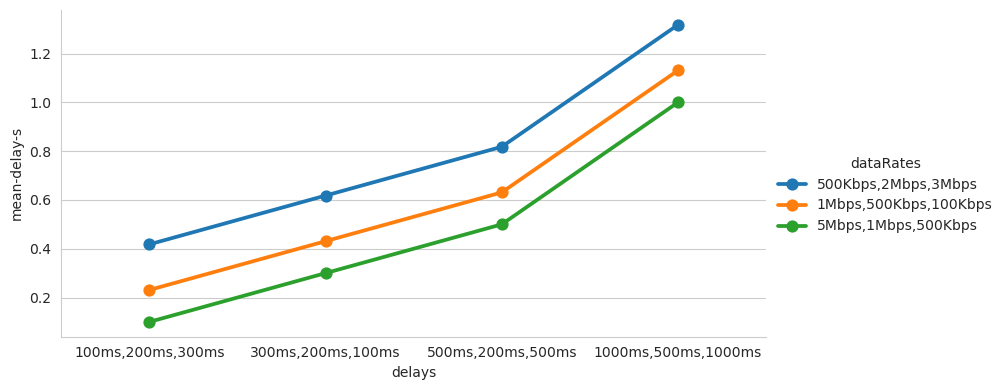

In [11]:

sns.catplot(data=results_delay,
            x='delays',
            y='mean-delay-s',
            hue='dataRates',
            kind='point',
            height=4,
            aspect=2)  # Width = height * aspect, so 5*2 = 10)
plt.show()

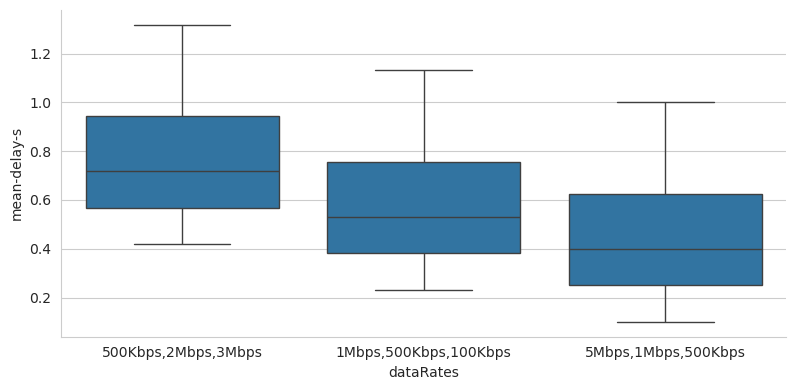

In [12]:
sns.catplot(data=results_delay,
            x='dataRates',#'delays',
            y='mean-delay-s',
            
            kind='box',
            height=4,
            aspect=2)
plt.show()

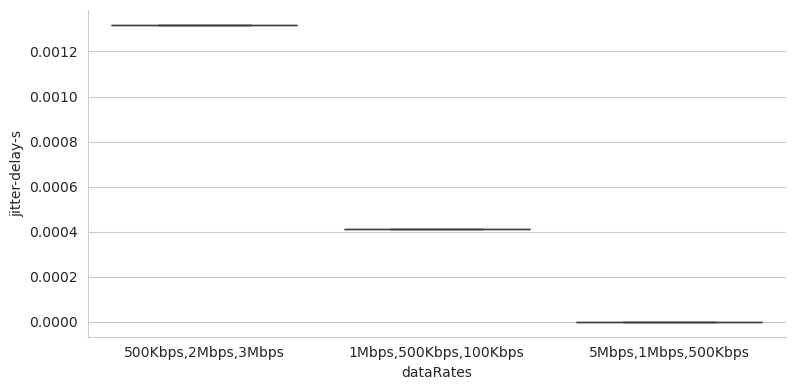

In [13]:
sns.catplot(data=results_jitter,
            x='dataRates',#'delays',
            y='jitter-delay-s',
            
            kind='box',
            height=4,
            aspect=2)
plt.show()

Automate the creation of those functions

In [14]:

feature_columns = [
    'flow_id', 'time_first_tx_s', 'time_first_rx_s', 'time_last_tx_s',
    'time_last_rx_s', 'delay_sum_s', 'jitter_sum_s', 'last_delay_s',
    'tx_bytes', 'rx_bytes', 'tx_packets', 'rx_packets', 'lost_packets',
    'times_forwarded', 'duration', 'throughput_Mbps', 'src', 'dst',
    'src_port', 'dst_port', 'protocol', 'mean_delay', 'mean-jitter',
    'flow_5tuple'
]

# Store dynamically created functions in a dictionary
generated_functions = {}

# Factory to create functions
def make_feature_function(feature_name):
    @sem.utils.output_labels([feature_name])
    def feature_fn(result):
        df = pd.read_csv(io.StringIO(result['output']['stdout'].strip()))
        return df[feature_name].iloc[0]
    return feature_fn

# Create and assign functions dynamically
for col in feature_columns:
    func_name = f"get_{col.replace('-', '_')}_flow"  # handle invalid characters
    generated_functions[func_name] = make_feature_function(col)

# Now you can call e.g.
# value = generated_functions['get_mean_delay_flow'](result)


In [15]:
# Dictionary to store individual results
results_dict = {}

for func_name, func in generated_functions.items():
    print(f"Running: {func_name}")
    df = campaign.get_results_as_dataframe(func, params=params)
    # Store each result using its output label as the key
    # Assumes the function returns a Series or single-column DataFrame
    results_dict[func_name] = df.reset_index(drop=True)


Running: get_flow_id_flow
Running: get_time_first_tx_s_flow
Running: get_time_first_rx_s_flow
Running: get_time_last_tx_s_flow
Running: get_time_last_rx_s_flow
Running: get_delay_sum_s_flow
Running: get_jitter_sum_s_flow
Running: get_last_delay_s_flow
Running: get_tx_bytes_flow
Running: get_rx_bytes_flow
Running: get_tx_packets_flow
Running: get_rx_packets_flow
Running: get_lost_packets_flow
Running: get_times_forwarded_flow
Running: get_duration_flow
Running: get_throughput_Mbps_flow
Running: get_src_flow
Running: get_dst_flow
Running: get_src_port_flow
Running: get_dst_port_flow
Running: get_protocol_flow
Running: get_mean_delay_flow
Running: get_mean_jitter_flow
Running: get_flow_5tuple_flow


In [16]:
from functools import reduce

# Get the list of common columns from the first DataFrame (excluding the feature)
common_cols = results_dict['get_mean_delay_flow'].columns[:-1].tolist()



# Before merging: rename the last column of each df to the feature name (dict key)
renamed_dfs = []
for feature_name, df in results_dict.items():
    feature_col = df.columns[-1]
    df_renamed = df.rename(columns={feature_col: feature_name})
    renamed_dfs.append(df_renamed)

# Merge all DataFrames on the common columns
merged_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols), renamed_dfs)


In [17]:
merged_df.head()

,numLinks,dataRates,delays,queueMaxSize,appRate,onTimeType,offTimeType,queueType,offTimeParam,transportType,...,get_duration_flow,get_throughput_Mbps_flow,get_src_flow,get_dst_flow,get_src_port_flow,get_dst_port_flow,get_protocol_flow,get_mean_delay_flow,get_mean_jitter_flow,get_flow_5tuple_flow
0,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.0157,0.463973,10.1.1.2,10.1.1.1,49153,9,17,0.418233,0.001318,10.1.1.2-10.1.1.1-49153-9-17
1,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.0157,0.463973,10.1.1.2,10.1.1.1,49153,9,17,0.418233,0.001318,10.1.1.2-10.1.1.1-49153-9-17
2,3,"500Kbps,2Mbps,3Mbps","300ms,200ms,100ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.2157,0.453904,10.1.1.2,10.1.1.1,49153,9,17,0.618233,0.001318,10.1.1.2-10.1.1.1-49153-9-17
3,3,"500Kbps,2Mbps,3Mbps","300ms,200ms,100ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.2157,0.453904,10.1.1.2,10.1.1.1,49153,9,17,0.618233,0.001318,10.1.1.2-10.1.1.1-49153-9-17
4,3,"500Kbps,2Mbps,3Mbps","500ms,200ms,500ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.4157,0.444262,10.1.1.2,10.1.1.1,49153,9,17,0.818233,0.001318,10.1.1.2-10.1.1.1-49153-9-17


Each row = 1 graph

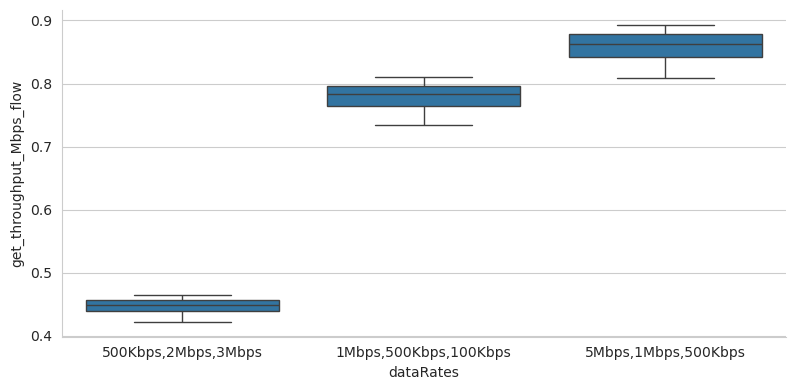

In [18]:
sns.catplot(data=merged_df,
            x='dataRates',#'delays',
            y='get_throughput_Mbps_flow',
            
            kind='box',
            height=4,
            aspect=2)
plt.show()

## Parse the pcap files

Parse the .pcap files in each experiemnt folder in the testResults

For now the flow id only has the src and dst ports of the UDP, handle the case 

In [19]:
import subprocess
import pandas as pd
from datetime import datetime
import numpy as np

def parse_pcap_to_df(filename):
    cmd = [
        "tshark",
        "-r", filename,
        "-T", "fields",
        "-e", "frame.number",          # Packet number
        "-e", "frame.time",            # Absolute time
        "-e", "ip.src",                # Source IP
        "-e", "ip.dst",                # Destination IP
        "-e", "ip.len",                # Total IP packet length
        #"-e", "ip.dsfield.dscp",       # DSCP
        #"-e", "ip.dsfield.ecn",        # ECN
        #"-e", "tcp.seq",               # TCP sequence number
        "-e", "frame.time_delta",      # Inter-frame delay (jitter)
        "-e", "tcp.srcport",
        "-e", "tcp.dstport",
        "-e", "udp.srcport",
        "-e", "udp.dstport",
        "-e", "ip.proto"
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)

    # Handle empty PCAP file
    if not result.stdout.strip():
        print(f"[WARNING] No packets found in {filename}. Returning empty DataFrame.")
        return pd.DataFrame(columns=[
            "Packet number", "Timestamp", "Source_IP", "Destination_IP", "Total_IP_packet_length",
            "DSCP", "ECN", "TCP_sequence_number", "Inter_frame_delay",
            "tcp_src_port", "tcp_dst_port", "udp_src_port", "udp_dst_port", "protocol",
            "TOS", "TOS_hex", "flow_id"
        ])
    lines = result.stdout.strip().split('\n')
    rows = [line.split('\t') for line in lines]

    df = pd.DataFrame(rows, columns=[
        "Packet number", "Timestamp", "Source_IP", "Destination_IP", "Total_IP_packet_length",
        #"DSCP", "ECN", "TCP_sequence_number", 
        "Inter_frame_delay",
        "tcp_src_port", "tcp_dst_port", "udp_src_port", "udp_dst_port", "protocol"
    ])
    # Create source and destination port columns depending on the protocol
    df['src_port'] = np.where(
        df['protocol'] == '6',  # TCP
        df['tcp_src_port'],
        df['udp_src_port']
    )

    df['dst_port'] = np.where(
        df['protocol'] == '6',  # TCP
        df['tcp_dst_port'],
        df['udp_dst_port']
    )

    df.drop(columns=['tcp_src_port', 'tcp_dst_port'], inplace=True)
    df.drop(columns=['udp_src_port', 'udp_dst_port'], inplace=True)
    protocol_map = {'6': 'TCP', '17': 'UDP'}
    df['protocol_name'] = df['protocol'].map(protocol_map).fillna(df['protocol'])


    # Now build the flow_id using the selected ports
    df['flow_id'] = (
        df['Source_IP'].astype(str) + '-' +
        df['Destination_IP'].astype(str) + '-' +
        df['src_port'].astype(str) + '-' +
        df['dst_port'].astype(str) + '-' +
        df['protocol'].astype(str)
        # + '-' + df['DSCP'].astype(str)  # optional
    )

    # Convert and clean fields
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    # Convert to datetime
     # Get just the time part
    df['Time_only'] = df['Timestamp'].dt.time
    df['Inter_frame_delay'] = pd.to_numeric(df['Inter_frame_delay'], errors='coerce')
    df['Total_IP_packet_length']=df['Total_IP_packet_length'].fillna(0).astype(int)
    #df['DSCP'] = pd.to_numeric(df['DSCP'], errors='coerce').fillna(0).astype(int)
    #df['ECN'] = pd.to_numeric(df['ECN'], errors='coerce').fillna(0).astype(int)

    # TOS (Type of Service) field
    #df['TOS'] = (df['DSCP'] << 2) | df['ECN']
    #df['TOS_hex'] = df['TOS'].apply(lambda x: f"0x{x:02x}")

    

    return df


In [20]:
pcap_file = '/home/nourhen_dev/ns3-workspace/testResults/data/2cc29e9d-9af1-4c45-b562-93a032e379dd/multi-link-0-1.pcap'
df_packets = parse_pcap_to_df(pcap_file)
df_packets.head()


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/2cc29e9d-9af1-4c45-b562-93a032e379dd/multi-link-0-1.pcap. Returning empty DataFrame.


,Packet number,Timestamp,Source_IP,Destination_IP,Total_IP_packet_length,DSCP,ECN,TCP_sequence_number,Inter_frame_delay,tcp_src_port,tcp_dst_port,udp_src_port,udp_dst_port,protocol,TOS,TOS_hex,flow_id


In [21]:
df_packets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Packet number           0 non-null      object
 1   Timestamp               0 non-null      object
 2   Source_IP               0 non-null      object
 3   Destination_IP          0 non-null      object
 4   Total_IP_packet_length  0 non-null      object
 5   DSCP                    0 non-null      object
 6   ECN                     0 non-null      object
 7   TCP_sequence_number     0 non-null      object
 8   Inter_frame_delay       0 non-null      object
 9   tcp_src_port            0 non-null      object
 10  tcp_dst_port            0 non-null      object
 11  udp_src_port            0 non-null      object
 12  udp_dst_port            0 non-null      object
 13  protocol                0 non-null      object
 14  TOS                     0 non-null      object
 15  TOS_hex           

In [22]:
df_packets['Total_IP_packet_length'].sum() #bytes

0

In [23]:
import os
import glob
import pandas as pd

def parse_all_pcaps_per_experiment(base_dir):
    # Dictionary to store parsed DataFrames per experiment
    experiment_data = {}

    # Loop over subdirectories in the base_dir
    for experiment_id in os.listdir(base_dir):
        experiment_path = os.path.join(base_dir, experiment_id)

        if os.path.isdir(experiment_path):
            # Get all .pcap files inside this experiment folder
            pcap_files = glob.glob(os.path.join(experiment_path, '*.pcap'))

            parsed_dfs = []
            for pcap_file in pcap_files:
                try:
                    df = parse_pcap_to_df(pcap_file)
                    if not df.empty:
                        df['file_path'] = pcap_file  # Optional
                        parsed_dfs.append(df)
                except Exception as e:
                    print(f"Error parsing {pcap_file}: {e}")

            # Combine parsed dataframes for this experiment
            if parsed_dfs:
                experiment_data[experiment_id] = pd.concat(parsed_dfs, ignore_index=True)
            else:
                print(f"No valid packets found in: {experiment_id}")

    return experiment_data


In [289]:

#df['Time_diff'] = df['Timestamp2'] - df['Timestamp1']

#df['Time_diff_seconds'] = df['Time_diff'].dt.total_seconds()


In [24]:
df_packets.head()

,Packet number,Timestamp,Source_IP,Destination_IP,Total_IP_packet_length,DSCP,ECN,TCP_sequence_number,Inter_frame_delay,tcp_src_port,tcp_dst_port,udp_src_port,udp_dst_port,protocol,TOS,TOS_hex,flow_id


In [25]:
df_packets.columns

Index(['Packet number', 'Timestamp', 'Source_IP', 'Destination_IP',
       'Total_IP_packet_length', 'DSCP', 'ECN', 'TCP_sequence_number',
       'Inter_frame_delay', 'tcp_src_port', 'tcp_dst_port', 'udp_src_port',
       'udp_dst_port', 'protocol', 'TOS', 'TOS_hex', 'flow_id'],
      dtype='object')

returns an empty dataframe in case the pcap file is empty

In [26]:
pcap_file = '/home/nourhen_dev/ns3-workspace/testResults/data/2cc29e9d-9af1-4c45-b562-93a032e379dd/multi-link-0-2.pcap'
df_packets = parse_pcap_to_df(pcap_file)
df_packets.shape

[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/2cc29e9d-9af1-4c45-b562-93a032e379dd/multi-link-0-2.pcap. Returning empty DataFrame.


(0, 17)

In [27]:
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))
base_dir = '/home/nourhen_dev/ns3-workspace/testResults/data'
experiment_dfs = parse_all_pcaps_per_experiment(base_dir)

# For example, show the first few rows from a specific experiment:
some_experiment = list(experiment_dfs.keys())[0]
print(f"Experiment ID: {some_experiment}")
print(experiment_dfs[some_experiment].head())


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/44176949-885e-4793-b7ff-fab8a02b4456/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/44176949-885e-4793-b7ff-fab8a02b4456/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/44176949-885e-4793-b7ff-fab8a02b4456/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/44176949-885e-4793-b7ff-fab8a02b4456/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/2b0e4c0a-1451-478b-94e9-a2a953986153/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/2b0e4c0a-1451-478b-94e9-a2a953986153/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/2b0e4c0a-1451-478b-94e9-a2a953986153/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/2b0e4c0a-1451-478b-94e9-a2a953986153/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1fd274e-3984-445d-b619-da9d76b56b2d/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1fd274e-3984-445d-b619-da9d76b56b2d/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1fd274e-3984-445d-b619-da9d76b56b2d/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1fd274e-3984-445d-b619-da9d76b56b2d/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/faabee7a-9915-4ff2-9c8d-0f60af358f78/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/faabee7a-9915-4ff2-9c8d-0f60af358f78/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/faabee7a-9915-4ff2-9c8d-0f60af358f78/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/faabee7a-9915-4ff2-9c8d-0f60af358f78/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/f4c9a295-69d2-4ac8-92c1-bd547230e578/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/f4c9a295-69d2-4ac8-92c1-bd547230e578/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/f4c9a295-69d2-4ac8-92c1-bd547230e578/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/f4c9a295-69d2-4ac8-92c1-bd547230e578/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/3c182d28-abc2-4376-8de6-d48d9235399b/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/3c182d28-abc2-4376-8de6-d48d9235399b/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/3c182d28-abc2-4376-8de6-d48d9235399b/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/3c182d28-abc2-4376-8de6-d48d9235399b/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/b3e30825-bc62-4801-ba86-142370b9addb/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/b3e30825-bc62-4801-ba86-142370b9addb/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/b3e30825-bc62-4801-ba86-142370b9addb/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/b3e30825-bc62-4801-ba86-142370b9addb/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/701253f6-6a9c-46b3-8990-2018a646d1c3/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/701253f6-6a9c-46b3-8990-2018a646d1c3/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/701253f6-6a9c-46b3-8990-2018a646d1c3/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/701253f6-6a9c-46b3-8990-2018a646d1c3/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/94e6660a-9e59-4b4c-a058-0a3dc1593e49/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/94e6660a-9e59-4b4c-a058-0a3dc1593e49/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/94e6660a-9e59-4b4c-a058-0a3dc1593e49/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/94e6660a-9e59-4b4c-a058-0a3dc1593e49/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/1a5ff790-d4c4-4bcb-8b03-3d3298a32e9c/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/1a5ff790-d4c4-4bcb-8b03-3d3298a32e9c/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/1a5ff790-d4c4-4bcb-8b03-3d3298a32e9c/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/1a5ff790-d4c4-4bcb-8b03-3d3298a32e9c/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/75b56d8e-22db-44c3-80c8-65fda4ed797a/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/75b56d8e-22db-44c3-80c8-65fda4ed797a/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/75b56d8e-22db-44c3-80c8-65fda4ed797a/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/75b56d8e-22db-44c3-80c8-65fda4ed797a/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1ec4caf-29d7-4d2d-818a-217f3b957dec/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1ec4caf-29d7-4d2d-818a-217f3b957dec/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1ec4caf-29d7-4d2d-818a-217f3b957dec/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/e1ec4caf-29d7-4d2d-818a-217f3b957dec/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/10f5a424-d6b0-4585-a59f-6213937a3d53/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/10f5a424-d6b0-4585-a59f-6213937a3d53/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/10f5a424-d6b0-4585-a59f-6213937a3d53/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/10f5a424-d6b0-4585-a59f-6213937a3d53/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7323c994-ace3-4308-a98b-3b072ed40154/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7323c994-ace3-4308-a98b-3b072ed40154/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7323c994-ace3-4308-a98b-3b072ed40154/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7323c994-ace3-4308-a98b-3b072ed40154/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7a3c68f7-0896-442e-bc98-a088cee87021/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7a3c68f7-0896-442e-bc98-a088cee87021/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7a3c68f7-0896-442e-bc98-a088cee87021/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/7a3c68f7-0896-442e-bc98-a088cee87021/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/06a1b273-ee06-4b71-bd82-6de39a72946d/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/06a1b273-ee06-4b71-bd82-6de39a72946d/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/06a1b273-ee06-4b71-bd82-6de39a72946d/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/06a1b273-ee06-4b71-bd82-6de39a72946d/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/53324e2c-38df-4b65-b5cc-aa8000a009d9/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/53324e2c-38df-4b65-b5cc-aa8000a009d9/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/53324e2c-38df-4b65-b5cc-aa8000a009d9/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/53324e2c-38df-4b65-b5cc-aa8000a009d9/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/a00fecfb-fe77-49c3-becd-2f04714bbf3c/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/a00fecfb-fe77-49c3-becd-2f04714bbf3c/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/a00fecfb-fe77-49c3-becd-2f04714bbf3c/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/a00fecfb-fe77-49c3-becd-2f04714bbf3c/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/0b09b1ff-cd95-41e8-ac87-9d3b8ba03662/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/0b09b1ff-cd95-41e8-ac87-9d3b8ba03662/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/0b09b1ff-cd95-41e8-ac87-9d3b8ba03662/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/0b09b1ff-cd95-41e8-ac87-9d3b8ba03662/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/56f80768-cf85-4932-a823-d8cf8abcbef9/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/56f80768-cf85-4932-a823-d8cf8abcbef9/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/56f80768-cf85-4932-a823-d8cf8abcbef9/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/56f80768-cf85-4932-a823-d8cf8abcbef9/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/74160ece-93ac-46b1-b089-e5d63df5bed6/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/74160ece-93ac-46b1-b089-e5d63df5bed6/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/74160ece-93ac-46b1-b089-e5d63df5bed6/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/74160ece-93ac-46b1-b089-e5d63df5bed6/multi-link-0-3.pcap. Returning empty DataFrame.


/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipykernel_182816/307263957.py:77: FutureWarning: Parsing 'CET' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/ef2cc7a2-e927-48a6-89d6-15df980e66d1/multi-link-1-3.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/ef2cc7a2-e927-48a6-89d6-15df980e66d1/multi-link-0-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/ef2cc7a2-e927-48a6-89d6-15df980e66d1/multi-link-1-2.pcap. Returning empty DataFrame.
[WARNING] No packets found in /home/nourhen_dev/ns3-workspace/testResults/data/ef2cc7a2-e927-48a6-89d6-15df980e66d1/multi-link-0-3.pcap. Returning empty DataFrame.
Experiment ID: 44176949-885e-4793-b7ff-fab8a02b4456
  Packet number                        Timestamp Source_IP Destination_IP  \
0             1 1970-01-01 01:00:02.501008+01:00  10.1.1.2       10.1.1.1   
1             2 1970-01-01 01:00:02.501808+01:00  10.1.1.2       10.1.1.1   
2             3 1970-01-01 01:00:02.502608+01:00  10.1.1.2   

In [28]:
# For example, show the first few rows from a specific experiment:
some_experiment = list(experiment_dfs.keys())[19]
print(f"Experiment ID: {some_experiment}")
experiment_dfs[some_experiment].head()

Experiment ID: fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54


,Packet number,Timestamp,Source_IP,Destination_IP,Total_IP_packet_length,Inter_frame_delay,protocol,src_port,dst_port,protocol_name,flow_id,Time_only,file_path
0,1,1970-01-01 01:00:02.002880+01:00,10.1.1.2,10.1.1.1,128,0.00000,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:02.002880,/home/nourhen_dev/ns3-workspace/testResults/da...
1,2,1970-01-01 01:00:02.004960+01:00,10.1.1.2,10.1.1.1,128,0.00208,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:02.004960,/home/nourhen_dev/ns3-workspace/testResults/da...
2,3,1970-01-01 01:00:02.007040+01:00,10.1.1.2,10.1.1.1,128,0.00208,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:02.007040,/home/nourhen_dev/ns3-workspace/testResults/da...
3,4,1970-01-01 01:00:02.009120+01:00,10.1.1.2,10.1.1.1,128,0.00208,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:02.009120,/home/nourhen_dev/ns3-workspace/testResults/da...
4,5,1970-01-01 01:00:02.011200+01:00,10.1.1.2,10.1.1.1,128,0.00208,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:02.011200,/home/nourhen_dev/ns3-workspace/testResults/da...


In [29]:
experiment_dfs[some_experiment].columns

Index(['Packet number', 'Timestamp', 'Source_IP', 'Destination_IP',
       'Total_IP_packet_length', 'Inter_frame_delay', 'protocol', 'src_port',
       'dst_port', 'protocol_name', 'flow_id', 'Time_only', 'file_path'],
      dtype='object')

In [30]:
experiment_dfs[some_experiment].shape

(8170, 13)

In [31]:
experiment_dfs[some_experiment]['flow_id'].value_counts()

flow_id
10.1.1.2-10.1.1.1-49153-9-17    8170
Name: count, dtype: int64

In [32]:
merged_df[merged_df['get_flow_5tuple_flow'] == "10.1.1.2-10.1.1.1-49153-9-17"].head(2) #returns all the merged_df because all the flows have the same identifiers in the simple case


,numLinks,dataRates,delays,queueMaxSize,appRate,onTimeType,offTimeType,queueType,offTimeParam,transportType,...,get_duration_flow,get_throughput_Mbps_flow,get_src_flow,get_dst_flow,get_src_port_flow,get_dst_port_flow,get_protocol_flow,get_mean_delay_flow,get_mean_jitter_flow,get_flow_5tuple_flow
0,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.0157,0.463973,10.1.1.2,10.1.1.1,49153,9,17,0.418233,0.001318,10.1.1.2-10.1.1.1-49153-9-17
1,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,9.0157,0.463973,10.1.1.2,10.1.1.1,49153,9,17,0.418233,0.001318,10.1.1.2-10.1.1.1-49153-9-17


In [33]:
experiment_dfs[some_experiment].groupby('file_path')['Total_IP_packet_length'].sum()

file_path
/home/nourhen_dev/ns3-workspace/testResults/data/fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54/multi-link-0-1.pcap    522880
/home/nourhen_dev/ns3-workspace/testResults/data/fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54/multi-link-1-1.pcap    522880
Name: Total_IP_packet_length, dtype: int64

Map the name of the experiment name folder to the parameters used to run it via the testResults.json file

In [34]:
import json
import pandas as pd

# Suppose your JSON is stored in variable `data`


# Open and read the JSON file
with open('/home/nourhen_dev/ns3-workspace/testResults/testResults.json', 'r') as file:
    data = json.load(file)


rows = []

# Extract from the "results" section
for run_key, run_val in data.get("results", {}).items():
    params = run_val.get("params", {})
    meta = run_val.get("meta", {})
    exp_id = run_key
    run_uuid = meta.get("id", None)

    # Combine all fields into a single row
    combined = {
        "run_key": exp_id,
        "run_uuid": run_uuid,
        **params
    }
    rows.append(combined)

df_experiments = pd.DataFrame(rows)


In [35]:
df_experiments.head(1)

,run_key,run_uuid,numLinks,dataRates,delays,queueMaxSize,appRate,onTimeType,offTimeType,queueType,offTimeParam,transportType,onTimeParam,packetSize,RngRun
0,1,94e6660a-9e59-4b4c-a058-0a3dc1593e49,3,"1Mbps,500Kbps,100Kbps","1000ms,500ms,1000ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,1.0,100.0,15


In [36]:
#df2['FileName'] = np.where(df1['ID'] == df2['ID'], df1['filename'], None)
columns_to_match = ['numLinks', 'dataRates', 'delays', 'offTimeType',
    'onTimeType', 'offTimeParam', 'transportType', 'appRate', 'queueType',
    'onTimeParam', 'queueMaxSize', 'packetSize', 'RngRun']

merged_df = merged_df.merge(
    df_experiments[['run_uuid'] + columns_to_match],
    on=columns_to_match,
    how='left'  # keeps all rows from merged_df
)

# Now 'run_uuid' will be added to merged_df where matches are found
merged_df.rename(columns={'run_uuid': 'file_name'}, inplace=True)


In [37]:
merged_df.head(1)

,numLinks,dataRates,delays,queueMaxSize,appRate,onTimeType,offTimeType,queueType,offTimeParam,transportType,...,get_throughput_Mbps_flow,get_src_flow,get_dst_flow,get_src_port_flow,get_dst_port_flow,get_protocol_flow,get_mean_delay_flow,get_mean_jitter_flow,get_flow_5tuple_flow,file_name
0,3,"500Kbps,2Mbps,3Mbps","100ms,200ms,300ms",100p,1Mbps,Constant,Constant,ns3::FifoQueueDisc,0.5,udp,...,0.463973,10.1.1.2,10.1.1.1,49153,9,17,0.418233,0.001318,10.1.1.2-10.1.1.1-49153-9-17,10f5a424-d6b0-4585-a59f-6213937a3d53


In [38]:
list(experiment_dfs.keys()) #list(merged_df['file_name'])

['44176949-885e-4793-b7ff-fab8a02b4456',
 '2b0e4c0a-1451-478b-94e9-a2a953986153',
 'e1fd274e-3984-445d-b619-da9d76b56b2d',
 'faabee7a-9915-4ff2-9c8d-0f60af358f78',
 'f4c9a295-69d2-4ac8-92c1-bd547230e578',
 '3c182d28-abc2-4376-8de6-d48d9235399b',
 'b3e30825-bc62-4801-ba86-142370b9addb',
 '701253f6-6a9c-46b3-8990-2018a646d1c3',
 '94e6660a-9e59-4b4c-a058-0a3dc1593e49',
 '1a5ff790-d4c4-4bcb-8b03-3d3298a32e9c',
 '5f5636a6-a111-4a02-af60-ffd64029c881',
 '75b56d8e-22db-44c3-80c8-65fda4ed797a',
 'e1ec4caf-29d7-4d2d-818a-217f3b957dec',
 '10f5a424-d6b0-4585-a59f-6213937a3d53',
 '7323c994-ace3-4308-a98b-3b072ed40154',
 '7a3c68f7-0896-442e-bc98-a088cee87021',
 '06a1b273-ee06-4b71-bd82-6de39a72946d',
 '53324e2c-38df-4b65-b5cc-aa8000a009d9',
 'a00fecfb-fe77-49c3-becd-2f04714bbf3c',
 'fc4687c0-ab8a-4a2b-9ff2-5e0c656efa54',
 '0b09b1ff-cd95-41e8-ac87-9d3b8ba03662',
 '56f80768-cf85-4932-a823-d8cf8abcbef9',
 '74160ece-93ac-46b1-b089-e5d63df5bed6',
 'ef2cc7a2-e927-48a6-89d6-15df980e66d1']

In [39]:
list(merged_df['file_name'])[1]

'5f5636a6-a111-4a02-af60-ffd64029c881'

In [40]:
# For example, show the first few rows from a specific experiment:
some_experiment = list(merged_df['file_name'])[1]
print(f"Experiment ID: {some_experiment}")
experiment_dfs[some_experiment].head(2)

Experiment ID: 5f5636a6-a111-4a02-af60-ffd64029c881


,Packet number,Timestamp,Source_IP,Destination_IP,Total_IP_packet_length,Inter_frame_delay,protocol,src_port,dst_port,protocol_name,flow_id,Time_only,file_path
0,1,1970-01-01 01:00:01.602880+01:00,10.1.1.2,10.1.1.1,128,0.00000,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:01.602880,/home/nourhen_dev/ns3-workspace/testResults/da...
1,2,1970-01-01 01:00:01.604960+01:00,10.1.1.2,10.1.1.1,128,0.00208,17,49153,9,UDP,10.1.1.2-10.1.1.1-49153-9-17,01:00:01.604960,/home/nourhen_dev/ns3-workspace/testResults/da...


In the simple case, the first value is the rx_bytes and the second value is the tx_bytes. We can find those in the flow stats of the corresponding flow by only using the index of the filename list used here (list(merged_df['file_name'])[1])

#### Verification of the stats of flow and pcap files

In [41]:
experiment_dfs[some_experiment].groupby('file_path')['Total_IP_packet_length'].sum()

file_path
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-0-1.pcap    522880
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-1-1.pcap    522880
Name: Total_IP_packet_length, dtype: int64

In [42]:
experiment_dfs[some_experiment].columns

Index(['Packet number', 'Timestamp', 'Source_IP', 'Destination_IP',
       'Total_IP_packet_length', 'Inter_frame_delay', 'protocol', 'src_port',
       'dst_port', 'protocol_name', 'flow_id', 'Time_only', 'file_path'],
      dtype='object')

In [420]:
#merged_df.columns

In [43]:
merged_df[['get_tx_packets_flow', 'get_rx_packets_flow', 'get_lost_packets_flow','get_mean_delay_flow','file_name']].iloc[1]

get_tx_packets_flow                                      7499
get_rx_packets_flow                                      4085
get_lost_packets_flow                                    3414
get_mean_delay_flow                                  0.418233
file_name                5f5636a6-a111-4a02-af60-ffd64029c881
Name: 1, dtype: object

In [44]:
experiment_dfs[some_experiment].groupby('file_path')['Inter_frame_delay'].describe()

,count,mean,std,min,25%,50%,75%,max
file_path,,,,,,,,
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-0-1.pcap,4085.0,0.002182,0.00293,0.0,0.00208,0.00208,0.00208,0.086881
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-1-1.pcap,4085.0,0.002182,0.00293,0.0,0.00208,0.00208,0.00208,0.086881


Compute bandwidth from the pcap file

In [45]:
df_experiment_time=experiment_dfs[some_experiment].groupby('file_path')['Timestamp'].describe()
(df_experiment_time['max']-df_experiment_time['min'])

file_path
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-0-1.pcap    0 days 00:00:08.913605
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-1-1.pcap    0 days 00:00:08.913605
dtype: object

In [46]:
experiment_dfs[some_experiment].groupby('file_path')['Total_IP_packet_length'].sum()/8.913605*8*1E-6 # en Mbps

file_path
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-0-1.pcap    0.469287
/home/nourhen_dev/ns3-workspace/testResults/data/5f5636a6-a111-4a02-af60-ffd64029c881/multi-link-1-1.pcap    0.469287
Name: Total_IP_packet_length, dtype: float64

Jitter ~ Standard deviation of inter-frame delays

In [47]:
merged_df[['get_mean_delay_flow','get_mean_jitter_flow','get_throughput_Mbps_flow']].iloc[1]

get_mean_delay_flow         0.418233
get_mean_jitter_flow        0.001318
get_throughput_Mbps_flow    0.463973
Name: 1, dtype: float64

## data transformation

In [ ]:
from torch_geometric.data import Data
import torch

In [158]:
#for index, row in merged_df.iterrows(): #iterate over experiments in the merged_df
#    print(row['dataRates'])

In [159]:
node_features = [
    'get_src_flow',         # e.g., 10.1.1.2
    'get_dst_flow',         # e.g., 10.1.1.1
    'get_src_port_flow',    # e.g., 49153
    'get_dst_port_flow',    # e.g., 9
    'get_protocol_flow'     # e.g., 17 (UDP)
]


In [160]:
edge_features = [
    'numLinks',
    'dataRates',              # Must be parsed to numeric
    'delays',                 # Same
    'offTimeParam',
    'onTimeParam',
    'appRate',
    'queueMaxSize',
    'packetSize',
    'RngRun',
    
    # Flow performance metrics
    'get_flow_id_flow',
    'get_time_first_tx_s_flow',
    'get_time_first_rx_s_flow',
    'get_time_last_tx_s_flow',
    'get_time_last_rx_s_flow',
    'get_delay_sum_s_flow',
    'get_jitter_sum_s_flow',
    'get_last_delay_s_flow',
    'get_tx_bytes_flow',
    'get_rx_bytes_flow',
    'get_tx_packets_flow',
    'get_rx_packets_flow',
    'get_lost_packets_flow',
    'get_times_forwarded_flow',
    'get_duration_flow',
    'get_throughput_Mbps_flow',
    'get_mean_delay_flow',
    'get_mean_jitter_flow'
]


Transform each row in your pandas.DataFrame into a torch_geometric.data.Data object

In [151]:

def parse_mbps(s): #converts everything to Mbps
    s = s.strip().lower()
    if 'mbps' in s:
        return float(s.replace('mbps', '').strip())
    elif 'kbps' in s:
        return float(s.replace('kbps', '').strip()) / 1000  # Convert Kbps → Mbps
    else:
        raise ValueError(f"Unrecognized bandwidth format: {s}")


def parse_ms(s):
    return float(s.replace('ms', '').strip())


time units in seconds, bandwidth in Mbps, data in bytes

In [189]:
1E-3

0.001

In [ ]:
def row_to_graph(row):
    num_links = row['numLinks']
    
    # Parse edge features
    delays = [parse_ms(d) for d in row['delays'].split(',')]
    rates = [parse_mbps(r) for r in row['dataRates'].split(',')]
    num_edges = len(delays)
        # Step 2: Create edge_index (from node 0 to node 1)
    edge_index = torch.tensor([[0] * num_edges, [1] * num_edges], dtype=torch.long)
    

    # Create edge index: source → hop1 → hop2 → dest
    # Edge index: all edges go from node 0 → node 1
    tx_bytes = float(row['get_tx_bytes_flow'])
    rx_bytes = float(row['get_rx_bytes_flow'])
    duration = float(row['get_duration_flow'])
    edge_attr = torch.tensor([
        [delays[i]*1E-3,rates[i], tx_bytes,rx_bytes,duration] #edge attributes
        for i in range(num_edges)
    ], dtype=torch.float)
   

     
     # Create 2 nodes (src, dst)
    x = torch.tensor([
        [row['get_dst_port_flow'], row['get_protocol_flow']], # Node 0: destination
        [row['get_src_port_flow'], row['get_protocol_flow']]   # Node 1: source
            ], dtype=torch.float)
    
    # Target variables
    y = torch.tensor([row['get_mean_delay_flow'], row['get_throughput_Mbps_flow'], row['get_mean_jitter_flow']], dtype=torch.float)#second,Mbps (bits not bytes),seconds

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [191]:
dataset = [row_to_graph(row) for _, row in merged_df.iterrows()]


In [192]:
print(dataset[0])


Data(x=[2, 2], edge_index=[2, 3], edge_attr=[3, 5], y=[3])


In [193]:
dataset[0].x,dataset[0].edge_index,dataset[0].edge_attr,dataset[0].y

(tensor([[9.0000e+00, 1.7000e+01],
         [4.9153e+04, 1.7000e+01]]),
 tensor([[0, 0, 0],
         [1, 1, 1]]),
 tensor([[1.0000e-01, 1.0000e+00, 9.5987e+05, 8.9152e+05, 8.8066e+00],
         [2.0000e-01, 2.0000e+00, 9.5987e+05, 8.9152e+05, 8.8066e+00],
         [3.0000e-01, 3.0000e+00, 9.5987e+05, 8.9152e+05, 8.8066e+00]]),
 tensor([2.3119e-01, 8.0987e-01, 4.1311e-04]))

In [166]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, edge_in, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(edge_in, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(edge_attr, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Pooling per graph
        x = self.lin(x)
        return x


In [168]:
from torch_geometric.loader import DataLoader

loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = GNN(edge_in=5, hidden_dim=64, out_dim=3)  # 3 outputs: delay, throughput, jitter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(100):
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()


RuntimeError: The expanded size of the tensor (12) must match the existing size (8) at non-singleton dimension 0.  Target sizes: [12, 64].  Tensor sizes: [8, 1]